# Mahan Madani
## Artificial Neural Networks 2nd Project

In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

### Download and load Cifar10 Dataset (60000 32x32 images):

In [3]:
transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, ), (0.5, ))])

train_set = tv.datasets.CIFAR10("./data", download=True, train=True, transform=transform)
test_set = tv.datasets.CIFAR10("./data", download=True, train=False, transform=transform) 

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True)

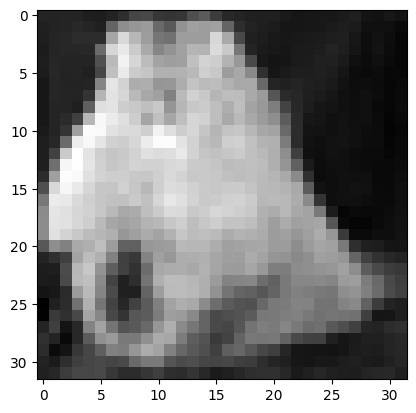

In [5]:
images = iter(test_loader)
input, target = next(images)
plt.imshow(input[0][0], cmap='gray')
plt.show()

### Define Loss function and train/test models
we'll use Croos Entropy as the loss function and SGD as the Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
def test_model(model):
    with torch.no_grad():
        test_loss = 0
        accuracy = 0
        model.eval()

        for input, target in test_loader:
            input = input.to(device)
            target = target.to(device)

            output = model.forward(input)
            loss = criterion(output, target)
            test_loss += loss.item()

            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    
    test_loss = test_loss / len(test_loader)
    model.test_loss_list.append(test_loss)
    
    test_accuracy = accuracy / len(test_loader)
    model.accuracy_list.append(accuracy)
    
    print(f"test loss: {test_loss},   test accuracy: {test_accuracy}")

In [8]:
def train_model(model, epochs, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        current_loss = 0
        model.train()

        for input, target in train_loader:
            optimizer.zero_grad()
            input = input.to(device)
            target = target.to(device)

            #forward-pass
            output = model.forward(input)
            loss = criterion(output, target)

            #backward-pass
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
            

        train_loss = current_loss / len(train_loader)
        model.train_loss_list.append(train_loss)

        # At completion of epoch
        print(f"Epoch: {i+1}/{epochs},   training loss: {train_loss}   ", end="")
        test_model(model)

In [21]:
def generate_loss_plot(model):
    plt.plot(model.train_loss_list, label = "Training loss")
    plt.plot(model.test_loss_list, label = "Test loss")
    plt.legend(frameon = False)
    plt.show()

In [22]:
def generate_accuracy_plot(model):
    plt.plot(model.accuracy_list, label = "Accuracy")
    plt.legend(frameon = False)
    plt.show()

In [11]:
def run_model(model, epochs, learning_rate):
    start_time = time()
    train_model(model, epochs, learning_rate)
    test_model(model)
    generate_loss_plot(model)
    generate_accuracy_plot(model)
    end_time = time()
    print(f"Total time spent: {end_time - start_time} seconds")

# Models

## define a parent class for all models
I created 4 models all inheriting from this class

In [43]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.train_loss_list = []
        self.test_loss_list = []
        self.accuracy_list = []


## Model 1 / 4:
No batch normalization -> low accuracy regardless of layer count and architecture

In [44]:
class Model_1(Model):
    def __init__(self):
        super().__init__()
        
        # nn.Conv2d(in_channels=, out_channels=, kernel_size=, stride=, padding=)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=2) 
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # nn.MaxPool2d(kernel_size=, stride=, padding=)

        self.conv4 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.fc1 = nn.Linear(15488, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(torch.relu(self.conv3(x)))

        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.pool2(torch.relu(self.conv6(x)))

        x = torch.flatten(x, 1) # flatten all dimensions

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch: 1/15,   training loss: 2.3038583498001097   test loss: 2.3027086234092713,   test accuracy: 0.10000000149011612
Epoch: 2/15,   training loss: 2.3024066038131714   test loss: 2.301681900024414,   test accuracy: 0.11109998822212219
Epoch: 3/15,   training loss: 2.2785588698387147   test loss: 2.1279982352256774,   test accuracy: 0.2289000153541565
Epoch: 4/15,   training loss: 1.977804215669632   test loss: 1.8826603066921235,   test accuracy: 0.3117000460624695
Epoch: 5/15,   training loss: 1.8618722491264343   test loss: 1.8080628442764282,   test accuracy: 0.3427000045776367
Epoch: 6/15,   training loss: 1.7751297497749328   test loss: 1.6926662623882294,   test accuracy: 0.39329996705055237
Epoch: 7/15,   training loss: 1.7080059854984284   test loss: 1.615603221654892,   test accuracy: 0.4157998561859131
Epoch: 8/15,   training loss: 1.6145874907970428   test loss: 1.5918617069721221,   test accuracy: 0.43549996614456177
Epoch: 9/15,   training loss: 1.515653513431549   test 

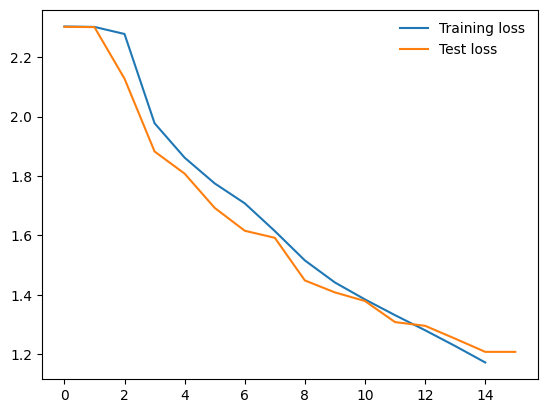

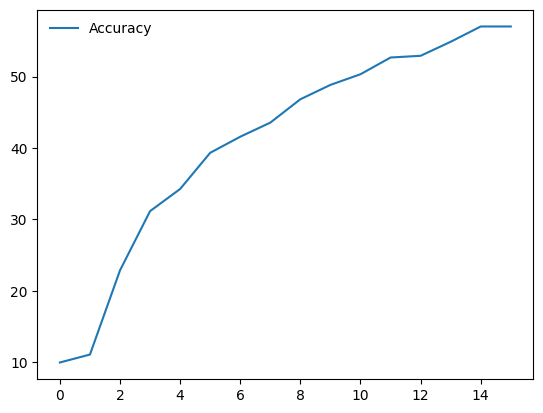

Total time spent: 282.8418245315552 seconds


In [45]:
model_1 = Model_1().to(device)
run_model(model_1, 15, 0.02)

## Model 2 / 4
Used a few batch normalization layers in addition to pooling and convolution layers

In [48]:
class Model_2(Model):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.conv3 = nn.Conv2d(128, 128, 3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn_conv = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 64, 3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn_linear = nn.BatchNorm1d(512)

        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(torch.relu(self.conv3(x)))
        x = torch.relu(self.bn_conv(x))

        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.pool2(torch.relu(self.conv6(x)))

        x = torch.flatten(x, 1)
        x = torch.relu(self.bn_linear(x))

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch: 1/15,   training loss: 1.7638855769634247   test loss: 1.3781113195419312,   test accuracy: 0.48890000581741333
Epoch: 2/15,   training loss: 1.181209222793579   test loss: 1.0781727248430253,   test accuracy: 0.6119000911712646
Epoch: 3/15,   training loss: 0.9430309902429581   test loss: 1.032150884270668,   test accuracy: 0.6298000812530518
Epoch: 4/15,   training loss: 0.8114228594303131   test loss: 1.0827862471342087,   test accuracy: 0.6442000865936279
Epoch: 5/15,   training loss: 0.720113158762455   test loss: 0.9466117656230927,   test accuracy: 0.6754999756813049
Epoch: 6/15,   training loss: 0.6442736569046974   test loss: 1.0099412435293198,   test accuracy: 0.674299955368042
Epoch: 7/15,   training loss: 0.5867763041257859   test loss: 0.769420425593853,   test accuracy: 0.7368000149726868
Epoch: 8/15,   training loss: 0.5300995957255363   test loss: 0.8469619280099869,   test accuracy: 0.7118998765945435
Epoch: 9/15,   training loss: 0.4835806922018528   test loss

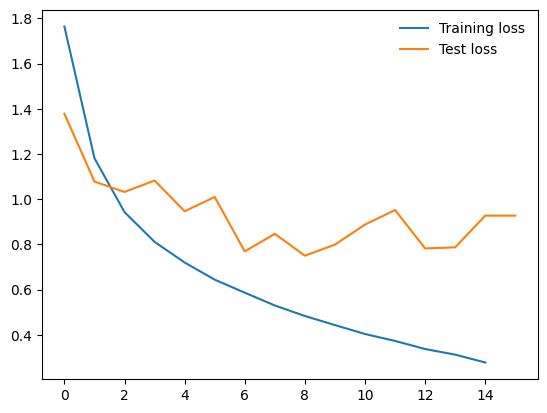

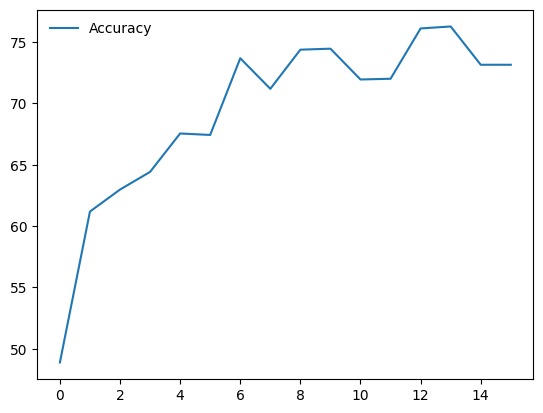

Total time spent: 305.40909481048584 seconds


In [63]:
model_2 = Model_2().to(device)
run_model(model_2, 15, 0.02)

## Model 3 / 4
Every layer has batch normalization applied to it

In [28]:
class Model_3(Model):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=2)
        self.bn_conv1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.bn_conv2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 3, stride=1)
        self.bn_conv3 = nn.BatchNorm2d(128)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn_conv4 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 64, 3, stride=1)
        self.bn_conv5 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 64, 3, stride=1)
        self.bn_conv6 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 32, 3, stride=1)
        self.bn_conv7 = nn.BatchNorm2d(32)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn_conv8 = nn.BatchNorm2d(32)
        self.bn_linear = nn.BatchNorm1d(512)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.bn_conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.bn_conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.bn_conv3(x))

        x = torch.relu(self.pool1(x))
        x = torch.relu(self.bn_conv4(x))

        x = torch.relu(self.conv4(x))
        x = torch.relu(self.bn_conv5(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.bn_conv6(x))
        x = torch.relu(self.conv6(x))
        x = torch.relu(self.bn_conv7(x))

        x = torch.relu(self.pool2(x))
        x = torch.relu(self.bn_conv8(x))
        
        x = torch.flatten(x, 1)
        x = torch.relu(self.bn_linear(x))

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch: 1/15,   training loss: 1.9838176245689392   test loss: 1.7084903419017792,   test accuracy: 0.3794998824596405
Epoch: 2/15,   training loss: 1.4692041232585906   test loss: 1.2936176979541778,   test accuracy: 0.5259000658988953
Epoch: 3/15,   training loss: 1.140569665670395   test loss: 1.0823978900909423,   test accuracy: 0.6103001236915588
Epoch: 4/15,   training loss: 0.9503904271125794   test loss: 1.052856302857399,   test accuracy: 0.6334001421928406
Epoch: 5/15,   training loss: 0.8279964175224305   test loss: 0.868349260687828,   test accuracy: 0.6946998834609985
Epoch: 6/15,   training loss: 0.7255373303294181   test loss: 0.8464140784740448,   test accuracy: 0.7116999626159668
Epoch: 7/15,   training loss: 0.6405080683231353   test loss: 0.8124887081980705,   test accuracy: 0.7253000140190125
Epoch: 8/15,   training loss: 0.5737138407230378   test loss: 0.8381160634756089,   test accuracy: 0.7205000519752502
Epoch: 9/15,   training loss: 0.5086051468849182   test los

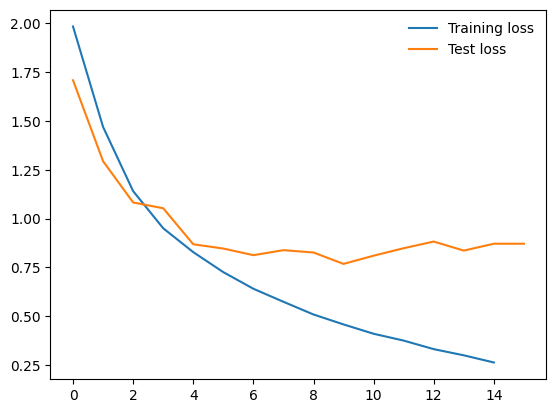

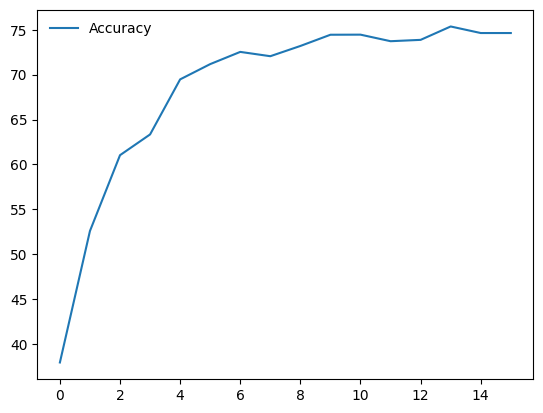

Total time spent: 350.1600649356842 seconds


In [62]:
model_3 = Model_3().to(device)
run_model(model_3, 15, 0.02)

## Model 4 / 4
Combination of dropout layers and batch normalization

In [56]:
class Model_4(Model):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1)
        self.bn_conv1 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn_conv2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 64, 3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1)
        self.bn_conv3 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 32, 3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn_linear = nn.BatchNorm1d(512)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.bn_conv1(x))
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.pool1(x))
        x = torch.relu(self.bn_conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.bn_conv3(x))
        
        x = torch.relu(self.conv6(x))
        x = torch.relu(self.pool2(x))
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        x = torch.relu(self.bn_linear(x))

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch: 1/15,   training loss: 1.998164383172989   test loss: 1.720619239807129,   test accuracy: 0.3590000867843628
Epoch: 2/15,   training loss: 1.5216328456401824   test loss: 1.3581404972076416,   test accuracy: 0.5117999911308289
Epoch: 3/15,   training loss: 1.2339227019548415   test loss: 1.351891279220581,   test accuracy: 0.5267000794410706
Epoch: 4/15,   training loss: 1.0425770720243455   test loss: 1.027278355360031,   test accuracy: 0.6332000494003296
Epoch: 5/15,   training loss: 0.9287045726776123   test loss: 0.9376264500617981,   test accuracy: 0.6739999651908875
Epoch: 6/15,   training loss: 0.8478893715143204   test loss: 0.8362469488382339,   test accuracy: 0.7139001488685608
Epoch: 7/15,   training loss: 0.7796215400099754   test loss: 0.7725078678131103,   test accuracy: 0.7292001247406006
Epoch: 8/15,   training loss: 0.730083317220211   test loss: 0.772117537856102,   test accuracy: 0.7351998686790466
Epoch: 9/15,   training loss: 0.6759622479081154   test loss: 

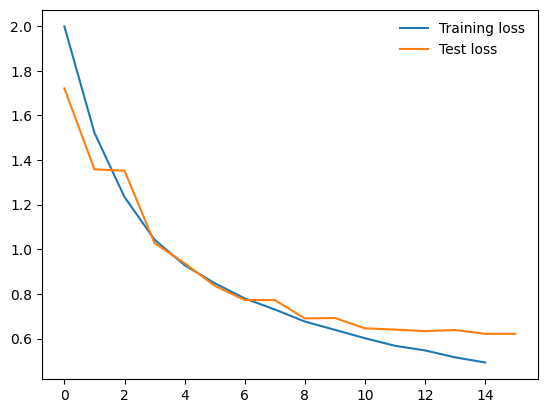

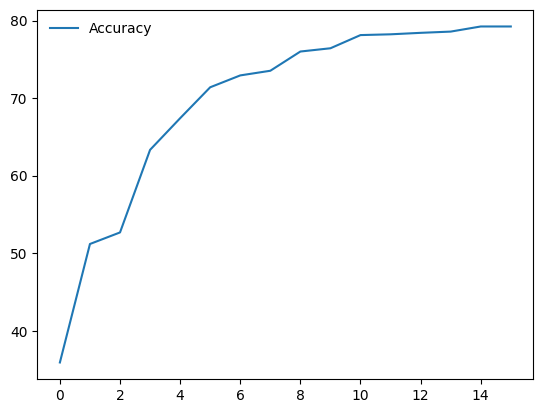

Total time spent: 331.9922602176666 seconds


In [57]:
model_4 = Model_4().to(device)
run_model(model_4, 15, 0.02)

## Report the depth effect of different hidden layers

In addition to the 4 models in this document, I tried multiple different combinations of layers to create models. Based on my own experience, there is no clear relationship between the number of layers and the accuracy of our model.
<br>I believe designing CNNs is all about finding a certain sweet spot that would maximize accuracy and minimize loss. Using the CIFAR-10 dataset also has its own limitations, as working with 32x32 pictures limits how many times we can use pooling and convolutional layers. if they’re used carelessly, we might end up with a 1x1 layer made out of a single pixel!
<br>other than pooling and convolutional layers, I used Batch Normalization and the Dropout technique to get better results.


## Report the effects of batch normalization

Batch Normalization seems to be a very effective technique for this type of Neural Network. Out of the 4 models I made, only Model 1 doesn’t utilize Batch Normalization and it also has the lowest accuracy. Overall it increased the model’s accuracy and slightly lowered the training time.

## Different architectures

The 4 models I presented in this document all feature slightly different architectures:
<br>Model 1: Simple CNN with 6 Convolutional Layers and 2 Pooling Layers
<br>Model 2: CNN with 6 Convolutional Layers, 2 Pooling Layers, and 2 Batch Normalizations
<br>Model 3: CNN with 6 Convolutional Layers, 2 Pooling Layers, and 9 Batch Normalizations
<br>Model 4: CNN with 6 Convolutional Layers, 2 Pooling Layers, 4 Batch Normalizations, and 2 Dropouts
<br>I couldn’t implement more complex architectures (ResNet, etc.) but from the ones I implemented, Model 4 seems to be the most accurate. 


## Calculate the Confusion Matrix

I calculated the Confusion Matrix for my most accurate model (Model 4).
<br>I used and modified the code from: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
to ensure I was calculating the matrix correctly and also to present it in a visually pleasing format

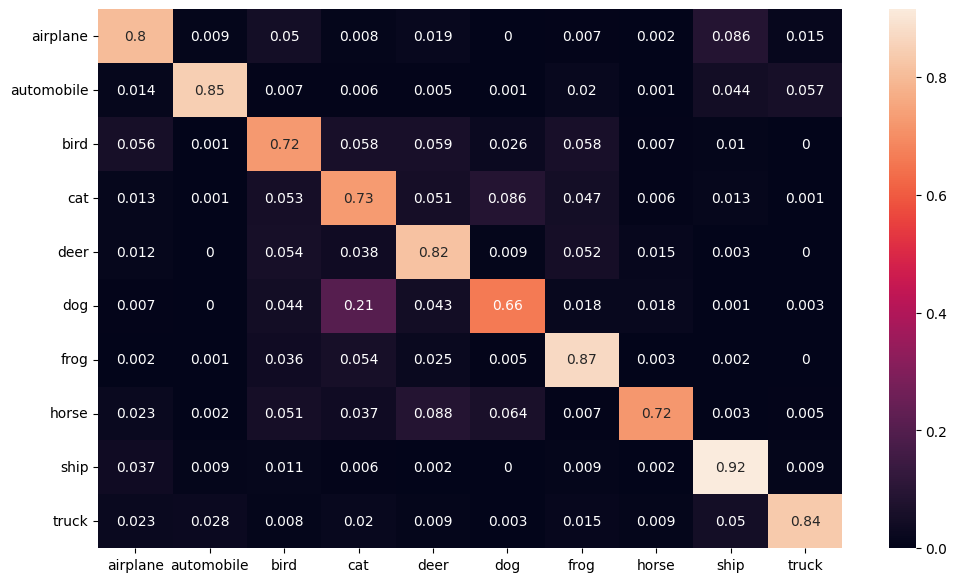

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_4(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Analysis
All values on the diameter of the Matrix are the times our model correctly guessed each input type. So for instance, the model has 0.85 chance of correctly identyfying automobiles. Values not on the diameter are the times the model guessed incorrectly.
<br> Based on these results, we can see that the model is most accurate when presented with a picture a ship (0.92), and least accurate when presented with a picture of a dog (0.66).